# 利用 torch.nn 实现前馈神经网络解决多分类任务

In [1]:
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np
import sys

In [2]:
input_size = 784  # 输入层神经元个数,因为像素大小为28*28，总共784个
# hidden_size = 256  # 隐藏层神经元个数
# hidden_size = 64
hidden_size = 128
num_classes = 10  # 分的类别，数字0-9
num_epochs = 30  # 训练次数
batch_size = 128  # 批处理大小，采用小批量梯度下降算法

## 1 下载 MNIST 手写体数据集

In [3]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./", train=True, transform= transforms.ToTensor(),download=True)
test_dataset = torchvision.datasets.MNIST(root="./", train=False, transform= transforms.ToTensor(),download=True)
# Data loader 实现数据加载功能
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  # shuffle= true表示每次迭代都随机加载训练集
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False)

## 2 模型定义及参数初始化

In [12]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(input_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
#     nn.Linear(hidden_size, hidden_size),
#     nn.ReLU(),
    # nn.LeakyReLU(),
    # nn.PReLU(),
    nn.Linear(hidden_size, num_classes)
    )

In [13]:
for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

## 3 定义交叉熵损失函数

In [14]:
loss = nn.CrossEntropyLoss()  # 采用多分类交叉熵损失函数

## 4 定义随机梯度下降函数

In [15]:
lr = 0.1
optimizer = optim.SGD(net.parameters(), lr=lr)

## 5 计算模型在测试数据集上的准确率

In [16]:
def evaluate_accuracy(data_inter,net,loss):
    acc_num,n = 0.0,0
    test_l_sum = 0.0
    for X,y in data_inter:
        acc_num+=(net(X).argmax(dim=1) == y).float().sum().item()
        l = loss(net(X),y).sum()
        test_l_sum+=l.item()
        n += y.shape[0]
    return acc_num/n,test_l_sum/n

## 6 模型训练，保存训练集和验证集的loss

In [17]:
x_l = []
train_loss = []
test_loss = []

In [18]:
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                optimizer = torch.optim.SGD(net.parameters(), lr=0.1)  # 学习率自适应的优化算法
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc,test_l = evaluate_accuracy(test_iter, net,loss)
        x_l.append(epoch + 1)
        train_loss.append(train_l_sum / n)
        test_loss.append(test_l)
        print('epoch %d, train_loss %.4f, train acc %.3f, test_loss %.4f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_l, test_acc))

In [19]:
def Draw_Loss_Curve(title):
    plt.figure(figsize=(15, 9))
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss Function")
    plt.plot(x_l, train_loss, label=u'Train Loss')
    plt.legend()
    p2 = plt.plot(x_l, test_loss, label=u'Test Loss')
    plt.legend()
    plt.title(title)
    plt.show()

In [12]:
train(net, train_loader, test_loader, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)

epoch 1, train_loss 0.0056, train acc 0.823, test_loss 0.0026, test acc 0.909
epoch 2, train_loss 0.0024, train acc 0.913, test_loss 0.0021, test acc 0.924
epoch 3, train_loss 0.0020, train acc 0.928, test_loss 0.0017, test acc 0.938
epoch 4, train_loss 0.0017, train acc 0.940, test_loss 0.0015, test acc 0.944
epoch 5, train_loss 0.0014, train acc 0.949, test_loss 0.0013, test acc 0.951
epoch 6, train_loss 0.0013, train acc 0.954, test_loss 0.0012, test acc 0.955
epoch 7, train_loss 0.0011, train acc 0.959, test_loss 0.0011, test acc 0.958
epoch 8, train_loss 0.0010, train acc 0.963, test_loss 0.0010, test acc 0.962
epoch 9, train_loss 0.0009, train acc 0.967, test_loss 0.0009, test acc 0.967
epoch 10, train_loss 0.0008, train acc 0.970, test_loss 0.0009, test acc 0.967
epoch 11, train_loss 0.0008, train acc 0.972, test_loss 0.0008, test acc 0.969
epoch 12, train_loss 0.0007, train acc 0.975, test_loss 0.0008, test acc 0.971
epoch 13, train_loss 0.0007, train acc 0.976, test_loss 0.000

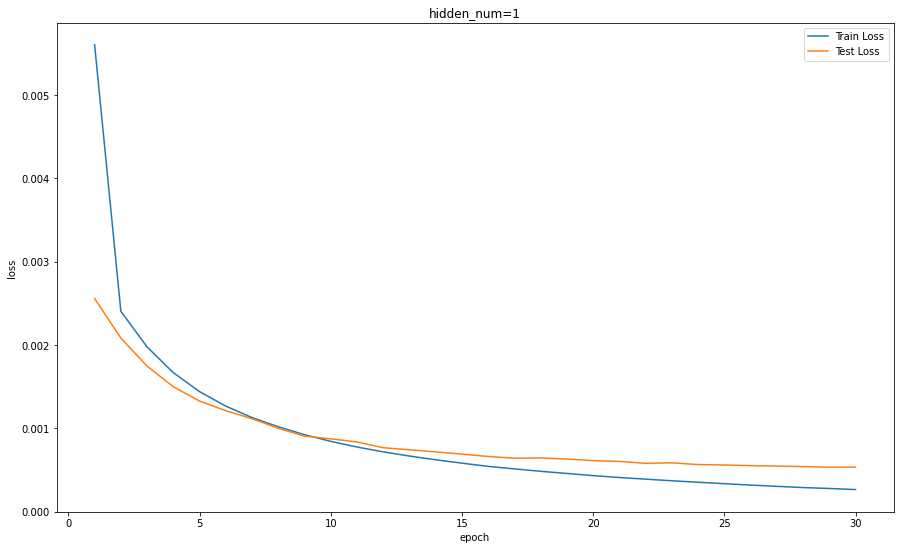

In [13]:
Draw_Loss_Curve('hidden_num=1')

In [20]:
train(net, train_loader, test_loader, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)

epoch 1, train_loss 0.0139, train acc 0.352, test_loss 0.0052, test acc 0.790
epoch 2, train_loss 0.0041, train acc 0.842, test_loss 0.0029, test acc 0.891
epoch 3, train_loss 0.0025, train acc 0.910, test_loss 0.0022, test acc 0.917
epoch 4, train_loss 0.0018, train acc 0.932, test_loss 0.0016, test acc 0.940
epoch 5, train_loss 0.0014, train acc 0.946, test_loss 0.0014, test acc 0.950
epoch 6, train_loss 0.0012, train acc 0.956, test_loss 0.0011, test acc 0.958
epoch 7, train_loss 0.0010, train acc 0.963, test_loss 0.0010, test acc 0.963
epoch 8, train_loss 0.0009, train acc 0.968, test_loss 0.0009, test acc 0.967
epoch 9, train_loss 0.0007, train acc 0.972, test_loss 0.0008, test acc 0.969
epoch 10, train_loss 0.0007, train acc 0.976, test_loss 0.0008, test acc 0.971
epoch 11, train_loss 0.0006, train acc 0.979, test_loss 0.0008, test acc 0.970
epoch 12, train_loss 0.0005, train acc 0.981, test_loss 0.0007, test acc 0.972
epoch 13, train_loss 0.0005, train acc 0.983, test_loss 0.000

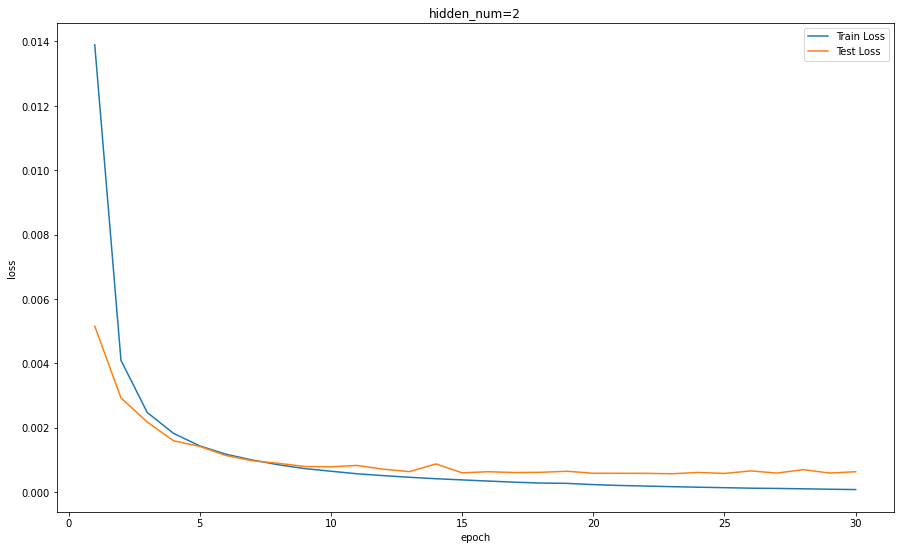

In [21]:
Draw_Loss_Curve('hidden_num=2')

In [41]:
train(net, train_loader, test_loader, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)

epoch 1, train_loss 0.0180, train acc 0.112, test_loss 0.0182, test acc 0.114
epoch 2, train_loss 0.0175, train acc 0.151, test_loss 0.0141, test acc 0.285
epoch 3, train_loss 0.0092, train acc 0.553, test_loss 0.0038, test acc 0.854
epoch 4, train_loss 0.0030, train acc 0.887, test_loss 0.0025, test acc 0.907
epoch 5, train_loss 0.0018, train acc 0.936, test_loss 0.0017, test acc 0.938
epoch 6, train_loss 0.0013, train acc 0.955, test_loss 0.0012, test acc 0.957
epoch 7, train_loss 0.0010, train acc 0.965, test_loss 0.0009, test acc 0.967
epoch 8, train_loss 0.0008, train acc 0.972, test_loss 0.0008, test acc 0.971
epoch 9, train_loss 0.0006, train acc 0.977, test_loss 0.0010, test acc 0.967
epoch 10, train_loss 0.0005, train acc 0.981, test_loss 0.0008, test acc 0.973
epoch 11, train_loss 0.0004, train acc 0.984, test_loss 0.0008, test acc 0.974
epoch 12, train_loss 0.0004, train acc 0.986, test_loss 0.0008, test acc 0.974
epoch 13, train_loss 0.0003, train acc 0.989, test_loss 0.001

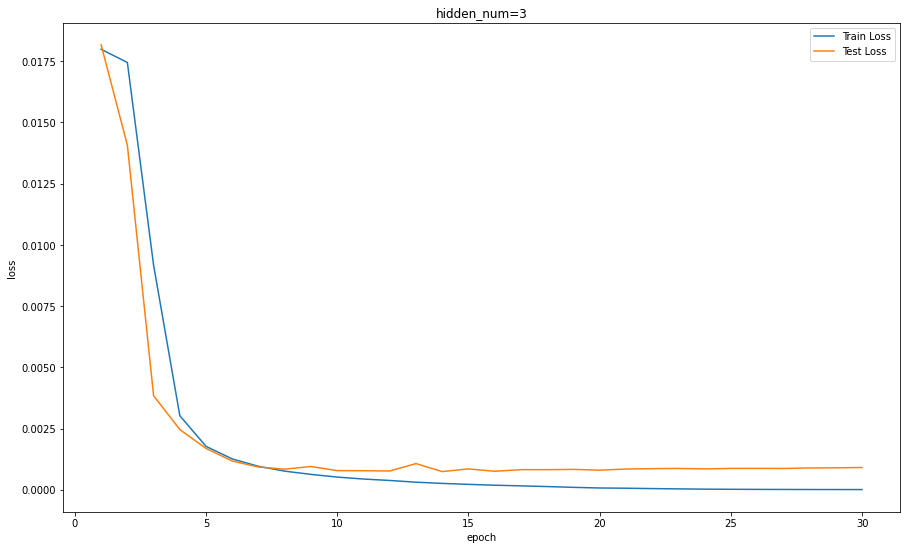

In [42]:
Draw_Loss_Curve('hidden_num=3')

In [52]:
train(net, train_loader, test_loader, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)

epoch 1, train_loss 0.0064, train acc 0.768, test_loss 0.0027, test acc 0.903
epoch 2, train_loss 0.0025, train acc 0.908, test_loss 0.0022, test acc 0.921
epoch 3, train_loss 0.0021, train acc 0.922, test_loss 0.0019, test acc 0.933
epoch 4, train_loss 0.0018, train acc 0.933, test_loss 0.0017, test acc 0.939
epoch 5, train_loss 0.0016, train acc 0.941, test_loss 0.0015, test acc 0.945
epoch 6, train_loss 0.0014, train acc 0.948, test_loss 0.0014, test acc 0.949
epoch 7, train_loss 0.0013, train acc 0.953, test_loss 0.0012, test acc 0.954
epoch 8, train_loss 0.0012, train acc 0.957, test_loss 0.0011, test acc 0.959
epoch 9, train_loss 0.0011, train acc 0.961, test_loss 0.0011, test acc 0.960
epoch 10, train_loss 0.0010, train acc 0.964, test_loss 0.0010, test acc 0.962
epoch 11, train_loss 0.0009, train acc 0.967, test_loss 0.0010, test acc 0.962
epoch 12, train_loss 0.0009, train acc 0.970, test_loss 0.0009, test acc 0.966
epoch 13, train_loss 0.0008, train acc 0.971, test_loss 0.000

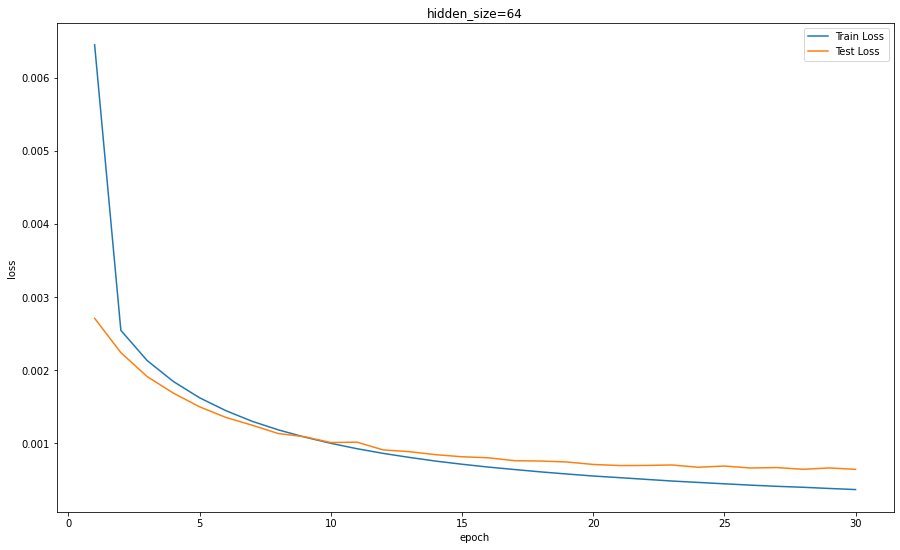

In [53]:
Draw_Loss_Curve('hidden_size=64')

In [63]:
train(net, train_loader, test_loader, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)

epoch 1, train_loss 0.0060, train acc 0.800, test_loss 0.0026, test acc 0.904
epoch 2, train_loss 0.0025, train acc 0.910, test_loss 0.0021, test acc 0.923
epoch 3, train_loss 0.0021, train acc 0.925, test_loss 0.0018, test acc 0.932
epoch 4, train_loss 0.0017, train acc 0.936, test_loss 0.0016, test acc 0.941
epoch 5, train_loss 0.0015, train acc 0.945, test_loss 0.0014, test acc 0.949
epoch 6, train_loss 0.0013, train acc 0.952, test_loss 0.0012, test acc 0.956
epoch 7, train_loss 0.0012, train acc 0.957, test_loss 0.0011, test acc 0.959
epoch 8, train_loss 0.0011, train acc 0.961, test_loss 0.0011, test acc 0.961
epoch 9, train_loss 0.0010, train acc 0.965, test_loss 0.0010, test acc 0.962
epoch 10, train_loss 0.0009, train acc 0.968, test_loss 0.0009, test acc 0.965
epoch 11, train_loss 0.0008, train acc 0.971, test_loss 0.0009, test acc 0.967
epoch 12, train_loss 0.0008, train acc 0.973, test_loss 0.0009, test acc 0.967
epoch 13, train_loss 0.0007, train acc 0.975, test_loss 0.000

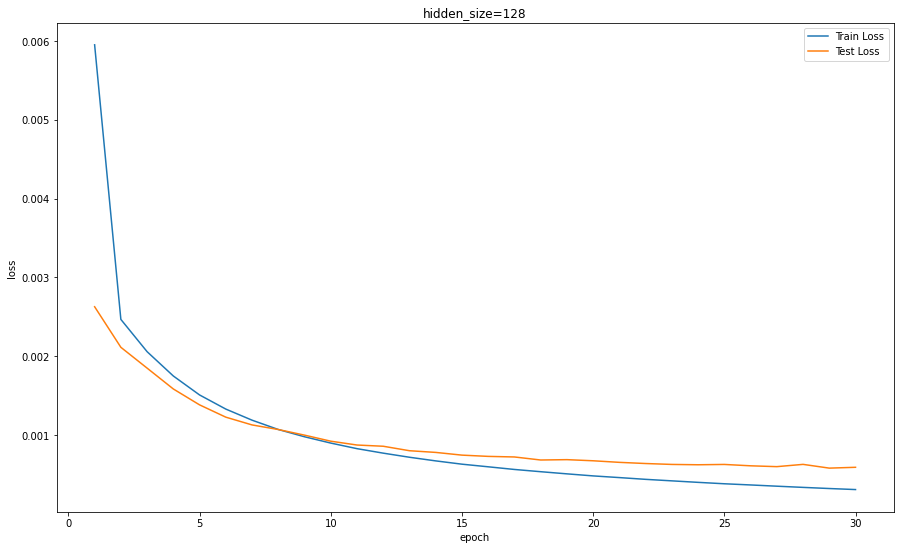

In [64]:
Draw_Loss_Curve('hidden_size=128')